In [13]:
from shape_analysis import *
import numpy as np
from pymongo import MongoClient
import matplotlib.pyplot as plt
from pathlib import Path
import re
from shapely.geometry import LinearRing, LineString, Polygon
import pandas as pd
from collections import OrderedDict
import pandas as pd

In [14]:
responder_path = '../../raw_data/first_data/DCM/Responder.xlsx'
responder_df = pd.read_excel(responder_path, engine='openpyxl')[:-3]
responder_map = {0: 'nonresponder', 1: 'responder'}
responder_df

,ID,responder
0,CRT_R_01,0
1,CRT_R_02,0
2,CRT_R_03,1
3,CRT_R_04,0
4,CRT_R_05,1
5,CRT_R_06,0
6,CRT_R_07,1
7,CRT_R_08,1
8,CRT_R_09,1
9,CRT_R_10,1


In [15]:
client = MongoClient()
db = client.echo_endo_contours
normalized_collection = db.normalized_collection
normalized_records = normalized_collection.find({})


n_time_points = 30
n_space_points = 20
record_records = {
    record['record_id']:
    Record.from_dict(record)
    for record in normalized_records
}
for record in record_records.values():
    record.interpolate_time(
        n_time_points=n_time_points,
        n_space_points=n_space_points
    )
interpolated_records = np.array([value.frames_as_array for value in record_records.values()])

In [16]:
es_id = list(record_records.values())[0].systolic_id
print('ES_id =', es_id)

ES_id = 10


In [17]:
record_ids = list(record_records.keys())
big_groups = {
    'norm': 0,
    'normQL': 1,
    'yn': 2,
    'IHD': 3,
    'CRT_before': 4,
    'CRT_after': 5
}
number_to_big_group = {
    val: key
    for key, val in big_groups.items()
}
small_groups = {
    'norm': 0,
    'normQL': 1,
    'yn': 2,
    'IHD': 3,
    'CRT_before_responder': 4,
    'CRT_before_nonresponder': 5,
    'CRT_after_responder': 6,
    'CRT_after_nonresponder': 7
}
number_to_small_group = {
    val: key
    for key, val in small_groups.items()
}

big_groups_column = []
small_groups_column = []
for record_id in record_ids:
    prefix = record_id.split('_')[0]
    postfix = record_id.split('_')[-1]
    if prefix == 'CRT':
        name = '_'.join(record_id.split('_')[:-1])
        find_response = responder_df[responder_df.ID == name].responder.to_numpy()
        if not len(find_response):
            response_binary = 0
        else:
            response_binary = find_response[0]
        response = responder_map[response_binary]
        if postfix == 'n':
            big_group = 'CRT_before'
        elif postfix == 'p':
            big_group = 'CRT_after'
        else:
            raise ValueError(record_id)
        small_group = f'{big_group}_{response}'
    else:
        big_group = prefix
        small_group = prefix
    big_groups_column.append(big_groups[big_group])
    small_groups_column.append(small_groups[small_group])
big_groups_column = np.array(big_groups_column)
small_groups_column = np.array(small_groups_column)

In [18]:
small_groups_column

array([7, 4, 4, 5, 7, 6, 6, 4, 7, 4, 5, 4, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 5, 7, 6, 7, 6, 5, 6, 4, 4, 6, 6, 4, 6, 7, 5, 4,
       6, 5, 7, 5, 7, 4, 6, 5, 5, 7, 4, 6, 5, 7, 5, 7, 5, 7, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [19]:
print(interpolated_records.shape)
interpolated_records = np.transpose(interpolated_records, (0,1,3,2))
print(interpolated_records.shape)

(156, 31, 20, 2)
(156, 31, 2, 20)


In [20]:
scaling = False

# global_mean, globally_aligned_shapes = generalized_procrustes_analysis(
#     interpolated_records.reshape(-1, interpolated_records.shape[2], interpolated_records.shape[3]),
#     rtol=1e-10,
#     atol=1e-10,
#     max_iter=10000,
#     scaling=scaling
# )
global_mean, globally_aligned_shapes = generalized_procrustes_analysis(
    interpolated_records.reshape(-1, interpolated_records.shape[2], interpolated_records.shape[3]),
    rtol=1e-10,
    atol=1e-10,
    max_iter=10000,
    scaling=scaling
)

9.42956464107278e-14


In [21]:
globally_aligned_shapes.shape

(4836, 2, 20)

155


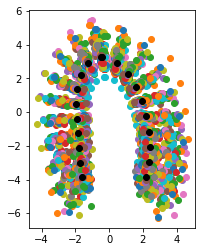

In [22]:
colors = 'orange', 'red', 'green', 'blue', 'purple', 'brown', 'yellow', 'grey', 'black'
# for i, shape in enumerate(globally_aligned_shapes.reshape(-1,16,2,20)[::,0]):
# for i, shape in enumerate(globally_aligned_shapes[:5*frames.shape[1]]):
for i, shape in enumerate(globally_aligned_shapes[::1*interpolated_records.shape[1]]):
    plt.scatter(*shape)
print(i)
plt.scatter(*global_mean, color='black')
# plt.scatter(*np.mean(globally_aligned_shapes, axis=0), color='red')
plt.gca().set_aspect('equal')

In [23]:
local_gpas = [
    generalized_procrustes_analysis(time_series, scaling=scaling)[0]
    for time_series in interpolated_records
]

2.6983740631259283e-10
1.2079643889460468e-11
2.0296586486228206e-10
1.603573728050511e-10
2.5644481441297297e-10
2.8724027217184293e-10
1.1562822307568467e-10
2.1607071683688045e-10
2.8571920196898167e-10
1.5708068349557063e-10
7.74784777664406e-11
1.2768123094068847e-11
1.256926250214173e-11
1.9771062240165455e-10
2.348924345769448e-10
2.0401809684503006e-10
2.7354878871226124e-10
2.530059961660364e-10
1.702107127224078e-10
6.056148701373976e-11
2.1165149329972325e-10
1.7275601150170242e-10
1.9449297171786146e-10
1.2795569732824539e-10
1.3482038122200087e-10
1.675345362198195e-10
1.2442508044388792e-10
1.9038508024578127e-10
1.6201858257722348e-10
1.1720225593249956e-10
1.641228719111301e-10
6.757660221291256e-11
5.684657792019003e-11
1.057552762280486e-10
1.0037305284935893e-10
1.0616648177917478e-10
1.6782780460427304e-10
1.1741436709428823e-10
7.849613768369592e-11
8.3814787214269e-11
1.9220659125320723e-10
2.0870249782003284e-10
1.0499592595752443e-10
8.650011848133879e-11
9.6507

In [24]:
linear_shifted = [
    [procrustes_analysis(local_gpas[i], frame, scaling=scaling) - local_gpas[i] + global_mean
     for frame in interpolated_records[i]]
    for i in range(len(local_gpas))
]
linear_shifted = np.array(linear_shifted)
print(linear_shifted.shape)

(156, 31, 2, 20)


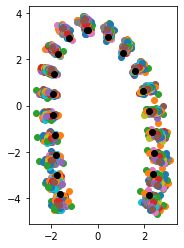

In [25]:
# for i, shape in enumerate(linear_shifted.reshape(-1, frames.shape[2], frames.shape[3])[:10*linear_shifted.shape[1]]):
for i, shape in enumerate(linear_shifted.reshape(-1, interpolated_records.shape[2], interpolated_records.shape[3])[::1*linear_shifted.shape[1]]):
    plt.scatter(*shape)
plt.scatter(*global_mean, color='black')
# plt.scatter(*np.mean(globally_aligned_shapes, axis=0), color='red')
plt.gca().set_aspect('equal')

(156, 31, 40)


Text(0, 0.5, 'explained variance')

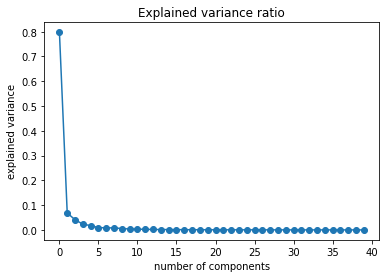

In [26]:
from sklearn.decomposition import PCA

pca = PCA(random_state=123)
pca_space_one = pca.fit_transform(
    linear_shifted.reshape(-1,linear_shifted.shape[2]*linear_shifted.shape[3])
).reshape(linear_shifted.shape[0], linear_shifted.shape[1], -1)
print(pca_space_one.shape)

plt.plot(pca.explained_variance_ratio_, marker='o');
plt.title('Explained variance ratio')
plt.xlabel('number of components')
plt.ylabel('explained variance')

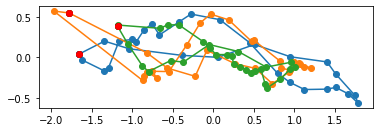

In [27]:
for trajectory in pca_space_one[:3]:
    plt.plot(trajectory[:,0], trajectory[:,1], marker='o')
    plt.plot(*trajectory[:,:2].T[:,0], color='black', marker='o')
    plt.plot(*trajectory[:,:2].T[:,-1], color='red', marker='o')
plt.gca().set_aspect('equal')

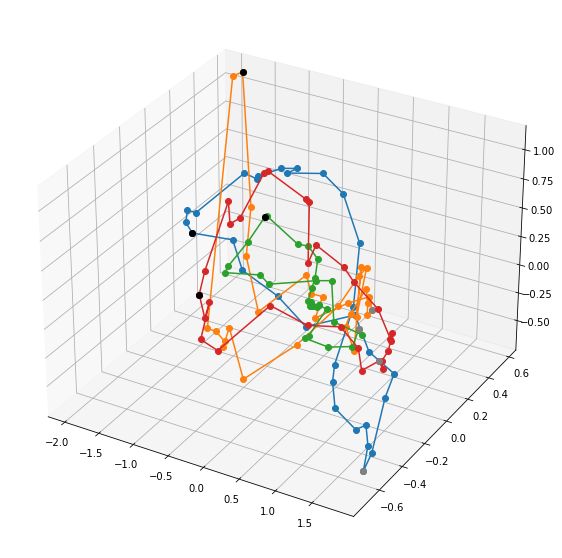

In [28]:
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

for trajectory in pca_space_one[:4]:
    ax.plot3D(*trajectory[:,:3].T, marker='o')
    ax.plot3D(*trajectory[:,:3].T[:,0], color='black', marker='o')
    ax.plot3D(*trajectory[:,:3].T[:,es_id], color='grey', marker='o')
    
# plt.gca().set_aspect('equal')

In [29]:
pca_space_one[0][:,:3].shape

(31, 3)

In [30]:
import matplotlib.animation

def update_line_and_text(frame_id, data, line, text):
    line.set_data(data[frame_id])
    text.set_text(f'{frame_id:02d}')
    return line, text,

animation_path = Path('./mean_animations')
animation_path.mkdir(exist_ok=True)

xlim = np.min(linear_shifted[:,:,0,:]), np.max(linear_shifted[:,:,0,:])
ylim = np.min(linear_shifted[:,:,1,:]), np.max(linear_shifted[:,:,1,:])

Writer = matplotlib.animation.writers['ffmpeg']
writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=1800)

for key in small_groups:
    mean_group_cycle = np.mean(linear_shifted[np.where(small_groups_column == small_groups[key])], axis=0)
    fig = plt.figure()
    l, = plt.plot([], [], marker='o', color='black')
    t = plt.text(0, 0, '')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.gca().set_aspect('equal')
    plt.title(f'{key} mean heart cycle')
    animation = matplotlib.animation.FuncAnimation(
        fig, update_line_and_text, mean_group_cycle.shape[0],
        fargs=(mean_group_cycle, l, t),
        interval=50, blit=True
    )
    animation.save(
        animation_path.joinpath(f'{key}_mean_heart_cycle.mp4'),
        writer=writer
    )
    plt.close(fig)

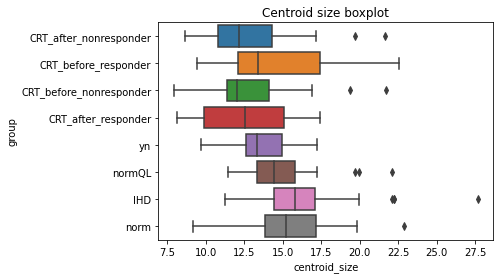

In [31]:
def get_centroid(shape):
    '''
    shape: (n x d) matrix
    n points in d-dimensional space
    '''
    return np.mean(shape, axis=0, keepdims=True)

def get_centroid_size(shape):
    centroid = get_centroid(shape)
    differences = shape - centroid
    distances = np.linalg.norm(differences, axis=0)
    return np.sum(distances)

def get_ed_es_vector(shape, es_id):
    return shape[es_id] - shape[0]

def get_ed_es_angles(shape, es_id):
    ed_es_vector = get_ed_es_vector(shape, es_id)
    pc1_pc2_angle = np.arctan2(*ed_es_vector[[0,1]])
    pc1_pc3_angle = np.arctan2(*ed_es_vector[[0,2]])
    return pc1_pc2_angle, pc1_pc3_angle

centroid_sizes = [get_centroid_size(shape) for shape in pca_space_one]
angles = [get_ed_es_angles(shape, es_id) for shape in pca_space_one]
pc1_pc2_angles = [angle_pair[0] for angle_pair in angles]
pc1_pc3_angles = [angle_pair[1] for angle_pair in angles]
df = pd.DataFrame({'centroid_size': centroid_sizes,
                   'pc1_pc2_angle': pc1_pc2_angles,
                   'pc1_pc3_angle': pc1_pc3_angles,
                   'group': small_groups_column,
                   'record_id': record_ids
                  }
                 )
df.group = df.group.map(number_to_small_group)
import seaborn as sns
sns.boxplot(x='centroid_size', y='group', data=df)
title = 'Centroid size boxplot'
plt.title(title)
plt.savefig(f'{title}.png')

In [32]:
df.sort_values(by='centroid_size')

,centroid_size,pc1_pc2_angle,pc1_pc3_angle,group,record_id
58,7.913304,1.028355,2.182388,CRT_before_nonresponder,CRT_R_23_n
38,8.134249,1.891272,1.442436,CRT_after_responder,CRT_R_10_p
59,8.650659,1.670040,2.551007,CRT_after_nonresponder,CRT_R_23_p
32,8.894257,1.624218,1.783976,CRT_after_responder,CRT_R_05_p
153,9.174006,1.454939,1.545785,norm,norm_22
...,...,...,...,...,...
109,22.257746,1.558208,1.525345,IHD,IHD_29
97,22.260783,1.483722,1.454262,IHD,IHD_17
1,22.565447,1.795069,1.893709,CRT_before_responder,CRT_R_03_n
154,22.912796,1.486005,1.669983,norm,norm_23


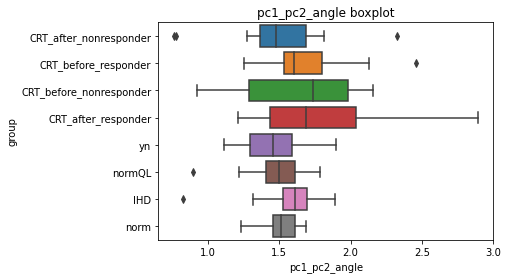

In [33]:
sns.boxplot(x='pc1_pc2_angle', y='group', data=df)
title = 'pc1_pc2_angle boxplot'
plt.title(title)
plt.savefig(f'{title}.png')

In [34]:
df.sort_values(by='pc1_pc2_angle')

,centroid_size,pc1_pc2_angle,pc1_pc3_angle,group,record_id
53,11.124633,0.758821,1.926790,CRT_after_nonresponder,CRT_R_20_p
61,9.897340,0.776639,2.303168,CRT_after_nonresponder,CRT_R_24_p
92,27.698272,0.827615,1.047929,IHD,IHD_12
74,16.022243,0.892266,0.943902,normQL,normQL_15
51,13.162828,0.919350,1.994487,CRT_before_nonresponder,CRT_R_19_n
...,...,...,...,...,...
55,10.160214,2.130983,1.239274,CRT_after_responder,CRT_R_21_p
42,12.054038,2.155228,1.462471,CRT_before_nonresponder,CRT_R_13_n
29,13.376517,2.329397,1.868618,CRT_after_nonresponder,CRT_R_01_p
39,12.379756,2.458562,1.693931,CRT_before_responder,CRT_R_11_n


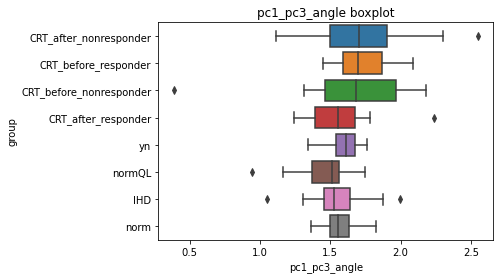

In [35]:
sns.boxplot(x='pc1_pc3_angle', y='group', data=df)
title = 'pc1_pc3_angle boxplot'
plt.title(title)
plt.savefig(f'{title}.png')

In [36]:
df.sort_values(by='pc1_pc3_angle')

,centroid_size,pc1_pc2_angle,pc1_pc3_angle,group,record_id
56,11.661862,1.981003,0.385348,CRT_before_nonresponder,CRT_R_22_n
74,16.022243,0.892266,0.943902,normQL,normQL_15
92,27.698272,0.827615,1.047929,IHD,IHD_12
46,13.382778,1.449531,1.116165,CRT_after_nonresponder,CRT_R_16_p
82,13.340415,1.348439,1.163662,normQL,normQL_23
...,...,...,...,...,...
36,17.559419,1.308474,2.091077,CRT_before_responder,CRT_R_09_n
58,7.913304,1.028355,2.182388,CRT_before_nonresponder,CRT_R_23_n
40,15.549860,2.894609,2.239281,CRT_after_responder,CRT_R_11_p
61,9.897340,0.776639,2.303168,CRT_after_nonresponder,CRT_R_24_p


0.011515897715317382


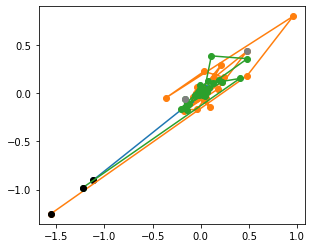

In [37]:
mean_trajectory, aligned_trajectories = generalized_procrustes_analysis(
    pca_space_one[:,:2],
    rtol=1e-10,
    atol=1e-10,
    max_iter=10000,
    scaling=False
)

for trajectory in aligned_trajectories[:3]:
    plt.plot(trajectory[0], trajectory[1], marker='o')
    plt.plot(*trajectory[:,0], color='black', marker='o')
    plt.plot(*trajectory[:,es_id], color='grey', marker='o')
plt.gca().set_aspect('equal')

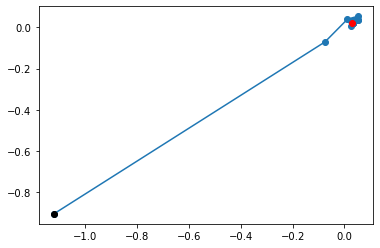

In [38]:
plt.plot(*mean_trajectory, marker='o');
plt.plot(*mean_trajectory[:,0], marker='o', color='black');
plt.plot(*mean_trajectory[:,es_id], marker='o', color='red');

In [39]:
xlim = np.min(pca_space_one[:,:,0]), np.max(pca_space_one[:,:,0])
ylim = np.min(pca_space_one[:,:,1]), np.max(pca_space_one[:,:,1])
zlim = np.min(pca_space_one[:,:,2]), np.max(pca_space_one[:,:,2])

trajectory_path = Path('./trajectory_graphs')
trajectory_path.mkdir(exist_ok=True)

for key in small_groups:
    mean_group_trajectory = np.mean(
        pca_space_one[np.where(small_groups_column == small_groups[key])],
        axis=0)
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')
    ax.plot3D(*mean_group_trajectory[:,:3].T, marker='o', color='blue')
    ax.plot3D(*mean_group_trajectory[0,:3], marker='o', color='black', label='ED')
    ax.plot3D(*mean_group_trajectory[es_id,:3], marker='o', color='red', label='ES')
    fig.legend()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(zlim)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    plt.title(f'{key} mean heart cycle')
    plt.savefig(trajectory_path.joinpath(f'{key}_mean_trajectory.png'))
    plt.close(fig)

In [40]:
aligned_trajectories.shape

(156, 2, 40)

Text(0.5, 0.92, 'norm_23')

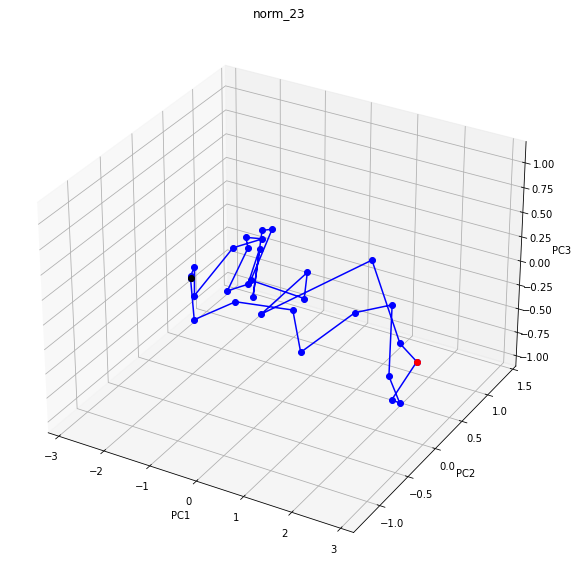

In [41]:
max_trajectory_id = np.subtract(
    np.unravel_index(np.argmax(pca_space_one[:,:,0]), pca_space_one[:,:,0].shape),
    0
)
mean_group_trajectory = pca_space_one[max_trajectory_id[0]]
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.plot3D(*mean_group_trajectory[:,:3].T, marker='o', color='blue')
ax.plot3D(*mean_group_trajectory[0,:3], marker='o', color='black', label='ED')
ax.plot3D(*mean_group_trajectory[es_id,:3], marker='o', color='red', label='ES')
ax.set_title(record_ids[max_trajectory_id[0]])

(156, 80)


Text(0, 0.5, 'explained variance')

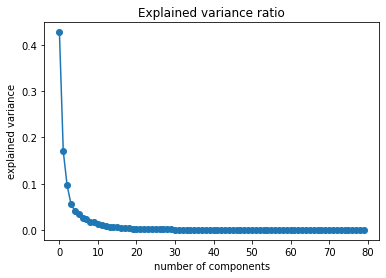

In [42]:
pca = PCA(random_state=123)
pca_space_two = pca.fit_transform(
    aligned_trajectories.reshape(aligned_trajectories.shape[0], -1)
)
print(pca_space_two.shape)

plt.plot(pca.explained_variance_ratio_, marker='o');
plt.title('Explained variance ratio')
plt.xlabel('number of components')
plt.ylabel('explained variance')

Text(0.5, 0.92, 'PCA space of trajectories shape')

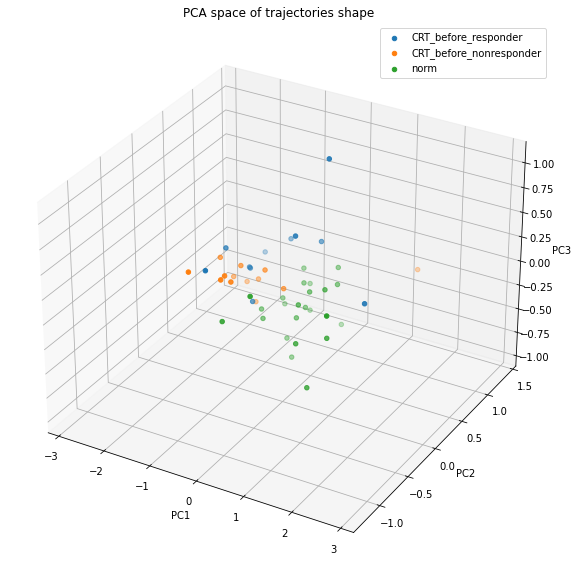

In [43]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

interesting_groups = ['CRT_before_responder', 'CRT_before_nonresponder', 'norm']
for key in interesting_groups:
    group_patients = pca_space_two[np.where(small_groups_column == small_groups[key])]
    ax.scatter3D(*group_patients[:,:3].T, label=key, marker='o')

ax.legend()
ax.set_title('PCA space of trajectories shape')

In [ ]:
record_ids = [0,10,20,30,40]
colors = ['orange', 'blue', 'red', 'black', 'brown', 'purple']

plt.figure(figsize=(20,20))
for j in range(len(record_ids)):
    for i in range(0, n_space_points, n_space_points//20):
        plt.plot(*interpolated_records[record_ids[j],:,i,:].T, color=colors[j])

record = Record.from_dict(normalized_collection.find({})[0])
record.interpolate_space(100)

frames = record.frames_as_array
frames = np.concatenate([frames, frames[[0]]])
frames.shape

def time_warp(n_frames, es_id):
    warped_ids = []
    for f_i in np.arange(n_frames):
        t_i = 0.35 * f_i / es_id
        if f_i > es_id:
            t_i = 0.35 + 0.65 * (f_i - es_id) / (n_frames - es_id + 1)
        warped_ids.append(t_i)
    return warped_ids

def interpolate_curve2(curve, dist, n_points=20):
    alpha = np.linspace(0, 1, n_points, endpoint=True)
    interpolator = scipy.interpolate.interp1d(dist, curve, kind='cubic', axis=0)
    return np.array(interpolator(alpha))

time = time_warp(len(frames)-1, record.systolic_id)
time.append(1)

spline_frames = []
for i in range(frames.shape[1]):
    spline_frames.append(interpolate_curve2(frames[:,i], time, 1000))
spline_frames = np.transpose(spline_frames, (1,0,2))
print(spline_frames.shape)

import scipy.fft
fft = scipy.fft.fft(spline_frames[:,0])
print('fft', fft.shape)
ifft = scipy.fft.ifft(fft[-200:])
print(ifft.shape)

plt.figure(figsize=(20,20))
for i in range(0,frames.shape[1],frames.shape[1]//20):
#     plt.plot(frames[:,i,0], frames[:,i,1], marker='o', color='blue')
    plt.plot(spline_frames[:,i,0], spline_frames[:,i,1], color='orange')

# plt.plot(fft[:,0], fft[:,1]);

# plt.plot(*ifft.T,color='black')
plt.gca().set_aspect('equal')